In [15]:
# Visualize lidar point cloud and Depth Anything point cloud
%load_ext autoreload
%autoreload 2

# Add Depth_Anything_V2 to the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import shutil

import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from tqdm import tqdm
import cv2

from PIL import Image

import matplotlib
matplotlib.use('agg')  # Or any other X11 back-end
import matplotlib.pyplot as plt
%matplotlib inline

from datasets.afm_kitti_360 import AFMKITTI360Dataset
from afm_kiss_icp.AFMOdometryPipeline import AFMOdometryPipeline
import matplotlib
matplotlib.use('agg')  # Or any other X11 back-end
import matplotlib.pyplot as plt
%matplotlib inline

dataset_path = '/storage/group/dataset_mirrors/01_incoming/kitti_360/KITTI-360'
poses_path = '/storage/group/dataset_mirrors/01_incoming/kitti_360/KITTI-360/data_poses'
config_file = '../config/KITTI_config.yaml'
sequences_ids = ['0000', '0002', '0003', '0004', '0005', '0006', '0007', '0009', '0010']

sequence_to_test = ['0000', '0002']

In [22]:
# Some utils...

# Save point cloud to obj file
def save_point_cloud_to_obj(points, filename, colors=None):
    with open(filename  + '.obj', 'w') as f:
        for i in range(points.shape[0]):
            # Write the vertices with colors
            point = points[i, :]
            if colors is not None:
                color = colors[i, :]
                f.write('v %f %f %f %f %f %f\n' % (point[0], point[1], point[2], color[0], color[1], color[2]))
            else:
                f.write('v %f %f %f\n' % (point[0], point[1], point[2]))



def save_point_cloud(pred, image, K, camera_to_velodyne, out_path, edge_filter=False):
    # Show prediction image (only for sanity purposes)
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

    # Flatten the arrays
    x = x.flatten() + 0.5
    y = y.flatten() + 0.5
    z = pred.flatten()
    colors = image.reshape(-1, 3)

    # Filter out points with zero depth
    # This is not really necessary, all points seem to have depth > 0
    # valid = z > 0
    # x = x[valid]
    # y = y[valid]
    # z = z[valid]
    # colors = colors[valid]

    # Convert 2D coordinates and depth to 3D points in camera coordinates
    uv1 = np.vstack((x, y, np.ones_like(x)))
    points = (np.linalg.inv(K).dot(uv1) * z).T
    # Add one extra dimension with ones to points (homogeneous coordinates)
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    # Convert points from camera coordinates to velodyne coordinates
    points = camera_to_velodyne.dot(points.T).T
    # Convert homogeneous coordinates to 3D coordinates
    points = points[:, :3] / points[:, 3:4]

    if edge_filter:
        mask = edge_filter(torch.from_numpy(points), threshold=0.15, neighborhood="8")
        points = points[mask]
        
    save_point_cloud_to_obj(points, out_path, colors)

def get_mask(index, sequence_id):
    mask_output_path = f'/data/masks/{sequence_id}/'
    sample_mask = str(index).zfill(10)
    mask_path = f"{mask_output_path}{sample_mask}.npz"
    return np.load(mask_path)['x']

def edge_filter(
    depth_map: torch.Tensor, threshold: float, neighborhood: str = "4"
) -> torch.Tensor:
    def _4_neighborhood(depth_map: torch.Tensor) -> torch.Tensor:
        depth_map = torch.stack(
            [
                depth_map[1:-1, 1:-1],
                depth_map[1:-1, :-2],
                depth_map[1:-1, 2:],
                depth_map[:-2, 1:-1],
                depth_map[2:, 1:-1],
            ],
            dim=0,
        )
        return depth_map

    def _8_neighborhood(depth_map: torch.Tensor) -> torch.Tensor:
        depth_map = torch.stack(
            [
                depth_map[1:-1, 1:-1],
                depth_map[1:-1, :-2],
                depth_map[1:-1, 2:],
                depth_map[:-2, 1:-1],
                depth_map[2:, 1:-1],
                depth_map[:-2, :-2],
                depth_map[2:, 2:],
                depth_map[:-2, 2:],
                depth_map[2:, :-2],
            ],
            dim=0,
        )
        return depth_map

    match neighborhood:
        case "4":
            depth_neighbors = _4_neighborhood(depth_map)
        case "8":
            depth_neighbors = _8_neighborhood(depth_map)
        case _:
            raise ValueError("Unknown neighborhood")

    depth_difference = torch.abs(depth_neighbors[1:] - depth_neighbors[0])
    mask = torch.all(depth_difference < threshold, dim=0)
    mask = torch.nn.functional.pad(mask, (1, 1, 1, 1), value=False)

    return mask



In [23]:
# Redefine Depth Anything V2 image2tensor to use CPU only
from Depth_Anything_V2.metric_depth.depth_anything_v2.dpt import DepthAnythingV2
from Depth_Anything_V2.metric_depth.depth_anything_v2.util.transform import Resize, NormalizeImage, PrepareForNet

class DepthAnythingV2CPU(DepthAnythingV2):
    
    def image2tensor(self, raw_image, input_size=518):        
        transform = Compose([
            Resize(
                width=input_size,
                height=input_size,
                resize_target=False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method='lower_bound',
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ])
        
        h, w = raw_image.shape[:2]
        
        # image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) * 255.0
        
        image = transform({'image': raw_image})['image']
        image = torch.from_numpy(image).unsqueeze(0)
        
        DEVICE = 'cpu'
        image = image.to(DEVICE)
        
        return image, (h, w)

# Load Depth Anything V2

In [24]:
# Create Depth Anything v2 model fine tuned on Virtual KITTI for metric depth

DEVICE = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
encoder = 'vitl'  # Use ViTL
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 80 # 20 for indoor model, 80 for outdoor model

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384],},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768],},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024],}
}

depth_anything_v2_metric = DepthAnythingV2CPU(**{**model_configs[encoder], 'max_depth': max_depth})
depth_anything_v2_metric.load_state_dict(torch.load('./../Depth_Anything_V2/metric_depth/checkpoints/depth_anything_v2_metric_vkitti_vitl.pth', map_location=DEVICE))
depth_anything_v2_metric.to(DEVICE).eval()
pass    # Done just to avoid output print

# KITTI Dataloader

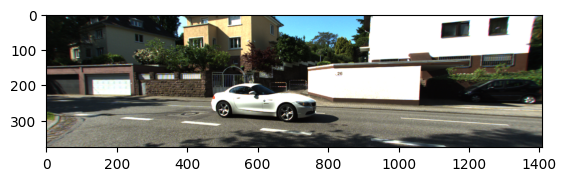

In [25]:
frame_id = 600
seq = sequence_to_test[1]
kitti360_sequence_img = AFMKITTI360Dataset(dataset_path, poses_path, seq, mode='2d_monocular', split_path=None, return_scans=False)

# load an image
left_image = kitti360_sequence_img[frame_id]['imgs'][0]
plt.imshow(left_image)

# Run Depth Anything Inference and Filtering

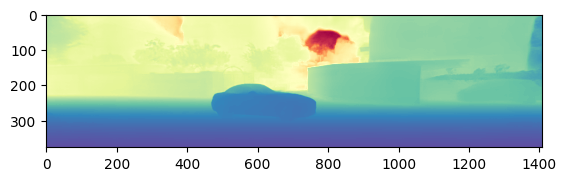

In [27]:
with torch.no_grad():
    metric_depth = depth_anything_v2_metric.infer_image(left_image) # HxW raw depth map

# Show the depth map
plt.imshow(metric_depth, cmap='Spectral_r')

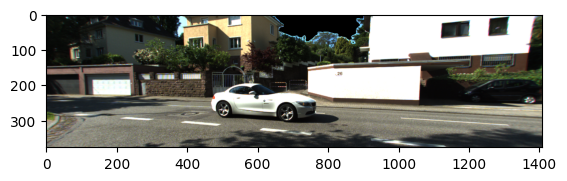

In [28]:
# Mask out the Sky
# NOTE: the mask needs to be stored already in /data/masks/{sequence_id}/ for each sequence
# This could be done with `generate_masks.py`. The pipeline does not store masks.
# Initially, this was done to avoid recomputing the masks every time, and to save GPU memory.

mask = get_mask(index=frame_id, sequence_id=seq)
masked_image_array = np.zeros_like(left_image)
masked_image_array[~mask] = left_image[~mask]
metric_depth_masked = np.zeros_like(metric_depth)
metric_depth_masked[~mask] = metric_depth[~mask]

# plt.imshow(metric_depth_masked)
plt.imshow(masked_image_array)

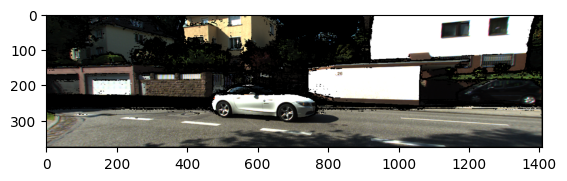

In [29]:
# Filter out the edges
mask_edges = edge_filter(torch.from_numpy(metric_depth), threshold=0.2, neighborhood="8").detach().cpu().numpy()
filtered_image = np.zeros_like(masked_image_array)
filtered_image[mask_edges] = masked_image_array[mask_edges]

metric_depth_filtered = np.zeros_like(metric_depth)
metric_depth_filtered[mask_edges] = metric_depth[mask_edges]
plt.imshow(filtered_image)

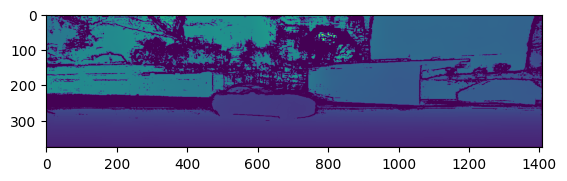

In [30]:
plt.imshow(metric_depth_filtered)

# Show More Examples of Depth Maps

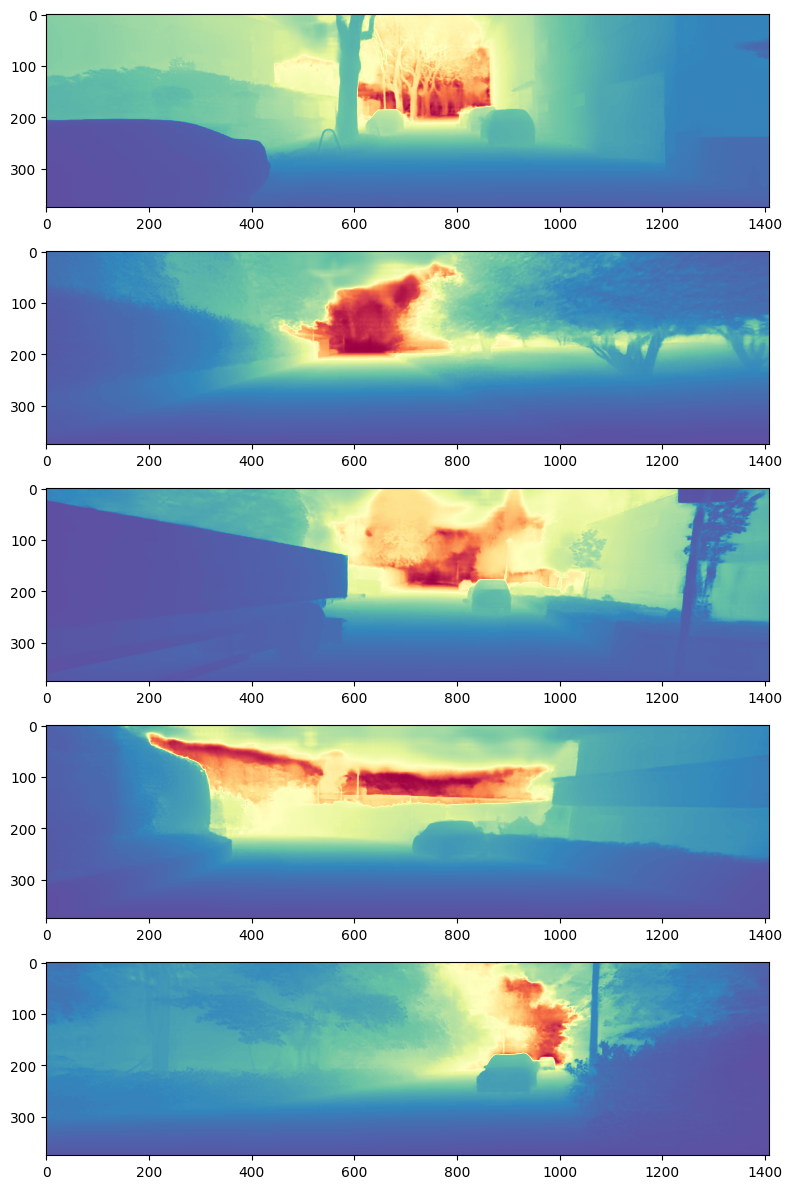

In [31]:
cmap = matplotlib.colormaps.get_cmap('Spectral_r')
num_images = 5000
num_cols = 1
num_rows = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
j = 0
for i in range(num_images):
    if i % 1000 == 0:
        item = kitti360_sequence_img.__getitem__(i)

        if "imgs" in item and len(item["imgs"]) > 0:  # Check if "imgs" exists and has at least one item
            img_l = item["imgs"][0]
            depth_metric_l = depth_anything_v2_metric.infer_image(img_l) # HxW raw depth map in numpy

            raw_depth = Image.fromarray(depth_metric_l.astype('uint16'))

            # depth_metric_l = 1/depth_metric_l
            depth = (depth_metric_l - depth_metric_l.min()) / (depth_metric_l.max() - depth_metric_l.min()) * 255.0
            depth = depth.astype(np.uint8)
            colored_depth = (cmap(depth)[:, :, :3] * 255).astype(np.uint8)

            gray_depth = Image.fromarray(depth)

            axes[j].imshow(depth_metric_l, cmap='Spectral_r')
            j+=1
plt.tight_layout()  # Adjust the spacing between subplots

# Save Pointclouds for Visualization

In [32]:
# K_perspective is in image coordinates [-1, 1], transform to pixel coordinates``
K = kitti360_sequence_img._calibs['K_perspective'].copy()
image_height, image_width = left_image.shape[0], left_image.shape[1]
K[0, 0] = (K[0, 0] / 2.0) * image_width
K[1, 1] = (K[1, 1] / 2.0) * image_height
K[0, 2] = ((K[0, 2] + 1.0) / 2.0) * image_width
K[1, 2] =  ((K[1, 2] + 1.0) / 2.0) * image_height
camera_to_velodyne = kitti360_sequence_img._calibs['T_pose_to_velo'].dot(kitti360_sequence_img._calibs['T_cam_to_pose']['00'])

# metric depth point cloud
out_path = os.path.join('./data/pointclouds/', os.path.splitext(os.path.basename('metr_DAV2'))[0])
save_point_cloud(metric_depth, left_image, K, camera_to_velodyne, out_path)

# segmented point cloud
out_path = os.path.join('./data/pointclouds/', os.path.splitext(os.path.basename('metr_DAV2_no_sky'))[0])
save_point_cloud(metric_depth_masked, masked_image_array, K, camera_to_velodyne, out_path)

# segmented and filtered point cloud
out_path = os.path.join('./data/pointclouds/', os.path.splitext(os.path.basename('metr_DAV2_no_sky_filtered'))[0])
save_point_cloud(metric_depth_filtered, filtered_image, K, camera_to_velodyne, out_path)